In [1]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical

Using TensorFlow backend.


# Setting up training and testing data

In [3]:
TRAIN_DIR = 'C:/Users/david/Desktop/train2/'
TEST_DIR = 'C:/Users/david/Desktop/test/'

ROWS = 227
COLS = 227
CHANNELS = 3
print(os.listdir(TRAIN_DIR)[:5])
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
train_images = train_dogs[:] + train_cats[:]
random.shuffle(train_images)
test_images =  test_images[:]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']
Processed 0 of 2500
Processed 250 of 2500
Processed 500 of 2500
Processed 750 of 2500
Processed 1000 of 2500
Processed 1250 of 2500
Processed 1500 of 2500
Processed 1750 of 2500
Processed 2000 of 2500
Processed 2250 of 2500
Processed 0 of 400
Processed 250 of 400
Train shape: (2500, 3, 227, 227)
Test shape: (400, 3, 227, 227)


C:\Users\david\anaconda3\envs\DL\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Cats and Dogs')

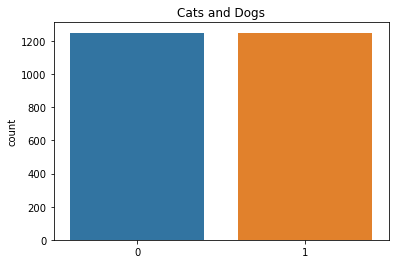

In [4]:
labels = []
for i in train_images:
    if 'dog' in i.split('/')[-1]:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels).set_title('Cats and Dogs')


In [ ]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer

# transforming labels to shape required by softmax
lb = LabelBinarizer()

label2 = lb.fit_transform(labels)

label2 = np.hstack((label2, 1 - label2))

(227, 227, 3)


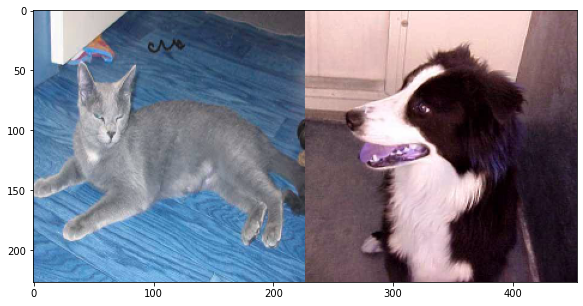

(227, 227, 3)


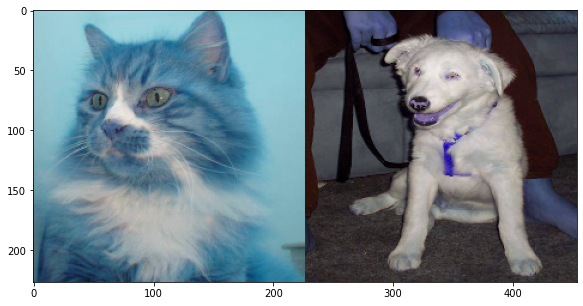

(227, 227, 3)


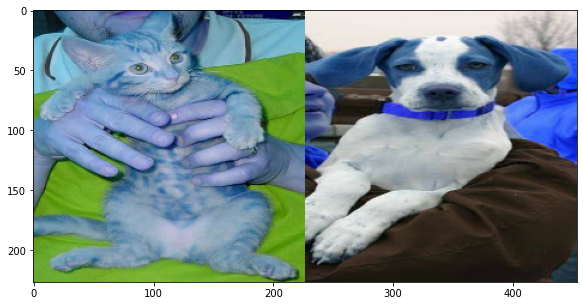

(227, 227, 3)


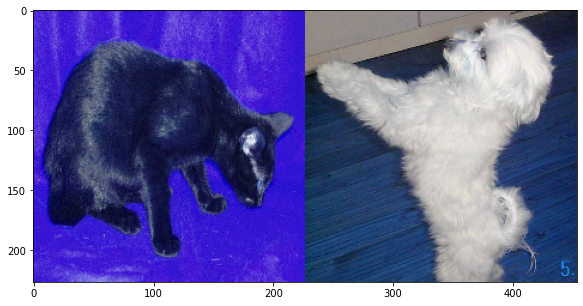

(227, 227, 3)


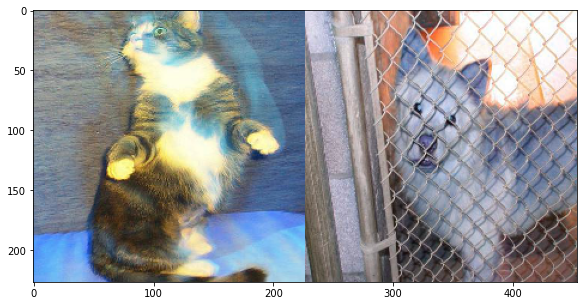

In [4]:
# inspecting the images
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    print(cat.shape)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,5):
    show_cats_and_dogs(idx)

# Setting up the models

In [ ]:
# RMSprop

In [7]:
from keras.layers import ZeroPadding2D
from keras.layers import BatchNormalization

model = Sequential()

model.add(Convolution2D(96, (11, 11),strides=(4,4), padding='same', input_shape=(3, ROWS, COLS), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=2, data_format = "channels_first"))
    
model.add(Convolution2D(256, (5, 5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=2, data_format = "channels_first"))
    
model.add(Convolution2D(384, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
    
model.add(Convolution2D(384, (1, 1), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
    
model.add(Convolution2D(256, (1, 1), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=2, data_format = 'channels_first'))
    
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 57, 96)         2636928   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 57, 96)         384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 28, 47)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 28, 256)        301056    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 28, 256)        1024      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 13, 127)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 13, 384)       

In [ ]:
# Nadam

In [7]:
from keras.layers import ZeroPadding2D
from keras.layers import BatchNormalization

model2 = Sequential()

model2.add(Convolution2D(96, (11, 11),strides=(4,4), padding='same', input_shape=(3, ROWS, COLS), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(3, 3), strides=2, data_format = "channels_first"))
    
model2.add(Convolution2D(256, (5, 5), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(3, 3), strides=2, data_format = "channels_first"))
    
model2.add(Convolution2D(384, (3, 3), padding='same', activation='relu'))
model2.add(BatchNormalization())
    
model2.add(Convolution2D(384, (1, 1), strides=(1,1), padding='same', activation='relu'))
model2.add(BatchNormalization())
    
model2.add(Convolution2D(256, (1, 1), strides=(1,1), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(3, 3), strides=2, data_format = 'channels_first'))
    
model2.add(Flatten())
model2.add(Dense(4096, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(4096, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(2, activation='softmax'))

model2.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 57, 96)         2636928   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 57, 96)         384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 28, 47)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 28, 256)        301056    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 28, 256)        1024      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 13, 127)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 13, 384)       

In [8]:
# USE CHECKPOINT TO SAVE BEST MODEL
checkpoint = ModelCheckpoint("best_model_nadam_Alexnet.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', period=1, save_weights_only=True)

In [11]:
nb_epoch = 10

## Callback for loss logging per epoch
class LossHistory(Callback):
    
    
    def on_train_begin(self, logs={}):
        self.x = 0
        self.losses = []
        self.val_losses = []
        print('Epoch ' + str(self.x) + '/' + str(nb_epoch))
        print(logs)
        
    def on_epoch_end(self, batch, logs={}):
        self.x+=1
        print('Epoch ' + str(self.x) + '/' + str(nb_epoch))
        print(logs)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        #model.save('my_model.h5')
        
es = EarlyStopping(monitor='val_loss',mode='min', verbose=1,patience=10)      
history = LossHistory()
lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3,verbose=1, factor=0.25, min_lr=0.0001)

In [12]:
model.fit(train, labels, batch_size=16, epochs=10,
          validation_split=0.2, verbose=1, shuffle=True, callbacks=[history,checkpoint,es,lr])

Train on 1600 samples, validate on 400 samples
Epoch 0/10
None
Epoch 1/10
1600/1600 [==============================] - 23s 14ms/step - loss: 0.5406 - accuracy: 0.7456 - val_loss: 0.5745 - val_accuracy: 0.6850
Epoch 1/10
{'val_loss': 0.5745239508152008, 'val_accuracy': 0.6850000023841858, 'loss': 0.5406394103169441, 'accuracy': 0.745625}

Epoch 00001: val_accuracy improved from -inf to 0.68500, saving model to best_model_rms_Alexnet.hdf5
Epoch 2/10
1600/1600 [==============================] - 23s 15ms/step - loss: 0.5543 - accuracy: 0.7575 - val_loss: 0.7913 - val_accuracy: 0.6825
Epoch 2/10
{'val_loss': 0.7912869429588318, 'val_accuracy': 0.6825000047683716, 'loss': 0.5542722523212433, 'accuracy': 0.7575}

Epoch 00002: val_accuracy did not improve from 0.68500
Epoch 3/10
1600/1600 [==============================] - 23s 15ms/step - loss: 0.5014 - accuracy: 0.7794 - val_loss: 0.5070 - val_accuracy: 0.7475
Epoch 3/10
{'val_loss': 0.5069880151748657, 'val_accuracy': 0.7475000023841858, 'lo

In [12]:
model2.fit(train, labels, batch_size=16, epochs=10,
          validation_split=0.2, verbose=1, shuffle=True, callbacks=[history,checkpoint,es,lr])

Train on 1600 samples, validate on 400 samples
Epoch 0/10
None
Epoch 1/10
1600/1600 [==============================] - 33s 20ms/step - loss: 0.6910 - accuracy: 0.5356 - val_loss: 0.6936 - val_accuracy: 0.5450
Epoch 1/10
{'val_loss': 0.6935664319992065, 'val_accuracy': 0.5450000166893005, 'loss': 0.6910204458236694, 'accuracy': 0.535625}

Epoch 00001: val_accuracy improved from -inf to 0.54500, saving model to best_model_nadam_Alexnet.hdf5
Epoch 2/10
1600/1600 [==============================] - 32s 20ms/step - loss: 0.7117 - accuracy: 0.5331 - val_loss: 0.9689 - val_accuracy: 0.5125
Epoch 2/10
{'val_loss': 0.9689139246940612, 'val_accuracy': 0.512499988079071, 'loss': 0.7116970974206924, 'accuracy': 0.533125}

Epoch 00002: val_accuracy did not improve from 0.54500
Epoch 3/10
1600/1600 [==============================] - 32s 20ms/step - loss: 0.7093 - accuracy: 0.5525 - val_loss: 0.6887 - val_accuracy: 0.5375
Epoch 3/10
{'val_loss': 0.6887378406524658, 'val_accuracy': 0.5375000238418579, 

# Inspecting the results and looking at predictions

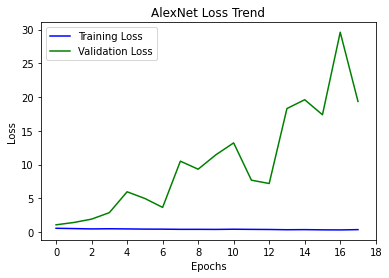

In [14]:
loss = history.losses[2:20]
val_loss = history.val_losses[2:20]

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('AlexNet Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

In [16]:
# Modify 'test1.jpg' and 'test2.jpg' to the images you want to predict on

from keras.models import load_model
from keras.preprocessing import image
import pandas as pd
import numpy as np

# dimensions of our images
#img_width, img_height = 224, 224

# load the model we saved

#model.load_weights('../input/model/my_model.h5')
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# predicting images
ids = []
labels = []
df = []
#for i in range(len(test_images)):
for i in range(len(test_images)):    
    #fig = read_image(test_images[i])
    img = test[i]
    #img = image.load_img('test', target_size=(img_width, img_height))
    x = np.expand_dims(img, axis=0)
    '''
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size=10)
    '''
    
    
    # pass the list of multiple images np.vstack()
    e = {'id':test_images[i].split('/')[-1].split('.')[0],
    'label':predictions[i][0]}
    if i%250==0:
        print('{} out of {} images labeled.'.format(i, len(test_images)))
    df.append(e)
    # print the classes, the images belong to
    '''
    print (classes)
    plt.figure(figsize=(10,5))
    plt.imshow(fig)
    plt.show()
    '''
    
df = pd.DataFrame(df)
print(df.head())

0 out of 400 images labeled.
250 out of 400 images labeled.
    id     label
0    1  0.306461
1   10  0.183021
2  100  0.509916
3  101  0.449264
4  102  0.595113


In [17]:
df = df.apply(pd.to_numeric, errors='ignore').sort_values('id')

df.index = np.arange(1, len(df)+1)
df = df.drop(columns = 'id')
df.index.name = 'id'
df.to_csv('submission.csv')

In [18]:
df.head(10)

label
id          
1   0.306461
2   0.726228
3   0.246638
4   0.999946
5   0.376489
6   0.535463
7   0.297976
8   0.719627
9   0.999995
10  0.183021

I am 56.15% sure this is a Cat


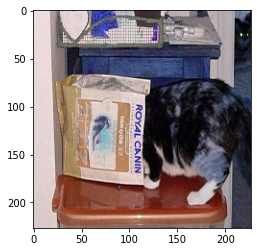

I am 61.40% sure this is a Cat


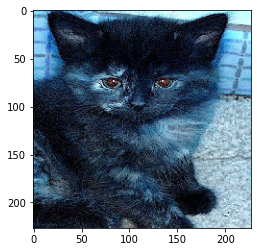

I am 69.42% sure this is a Dog


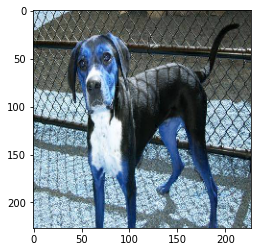

I am 100.00% sure this is a Cat


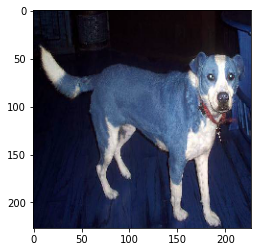

I am 83.26% sure this is a Cat


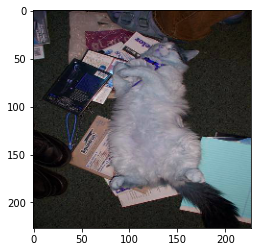

I am 56.39% sure this is a Dog


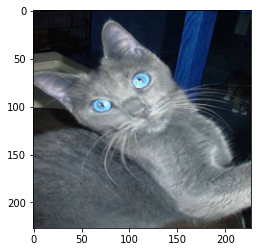

I am 51.50% sure this is a Dog


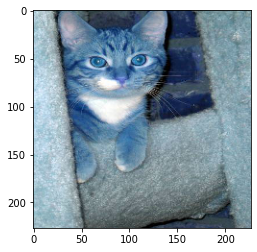

I am 62.64% sure this is a Cat


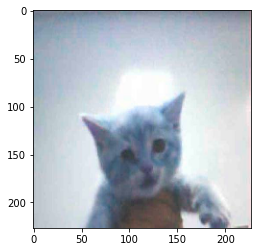

I am 77.48% sure this is a Dog


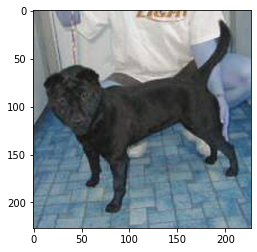

I am 87.82% sure this is a Cat


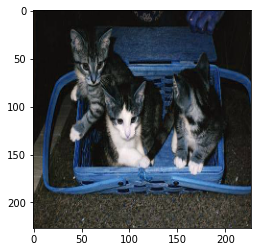

I am 90.55% sure this is a Dog


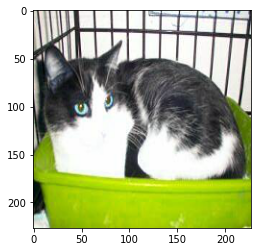

I am 99.34% sure this is a Cat


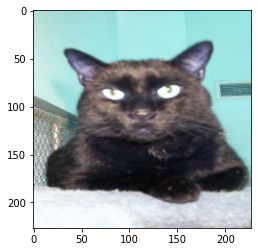

I am 55.75% sure this is a Dog


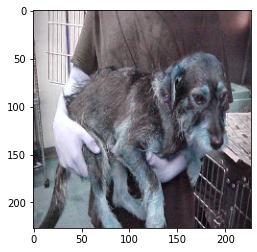

I am 57.20% sure this is a Cat


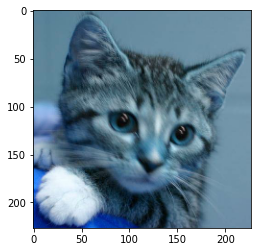

I am 58.93% sure this is a Dog


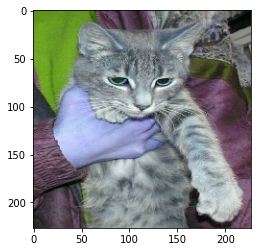

I am 85.26% sure this is a Dog


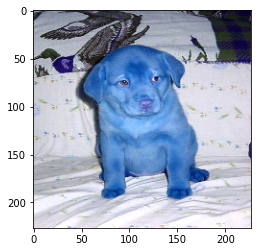

I am 78.87% sure this is a Cat


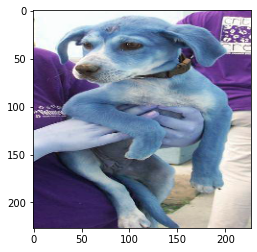

I am 88.14% sure this is a Cat


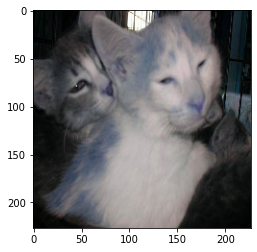

I am 79.88% sure this is a Cat


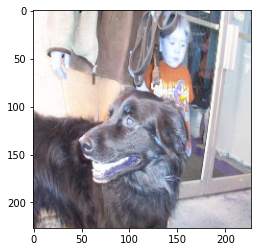

I am 56.98% sure this is a Cat


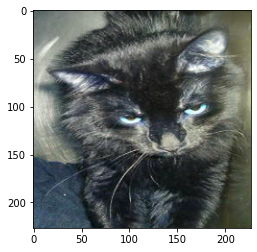

In [20]:
for i in range(50,70):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()

In [ ]:
print(predictions[:20])